# Статистика, DS-поток
## Задание SP.7

Задача 1: Бутстрепные доверительные интервалы для ML-моделей.
▫️ Наличие решения. (40.0)
▫️ Нет пояснений . Комм. Почему мы получили те или иные значения интервалов. (-3.0)
▫️ Нет сравнения интервалов случайного леса и рижд регрессии. (-3.0)
▫️ Нет сравнения 3 интервалов между собой. (-3.0)
▫️ Нет визуализации. (-10.0)
Баллы: 21.0 / 40.0

Задача 2: Точное значение статистики Колмогорова.
▫️ Наличие решения. (30.0)
▫️ Ошибка в краевых случаях. Комм. Не использованы пределы слева и справа. (-10.0)
Баллы: 20.0 / 30.0

Задача 3: Отрисовка ЭФР.
▫️ Наличие решения. (21.0)
▫️ Наличие отрисовки равномерного. (3.0)
▫️ Наличие отрисовки нормального. (3.0)
▫️ Наличие отрисовки экспоненциального. (3.0)
▫️ Нет пояснения, почему ядерная оценка не так хорошая для равномерного и эксп распределений. Комм. Чем эти два распределения отличаются от нормального . (-2.5)
▫️ Нет графиков истинных значений. (-3.0)
Баллы: 24.5 / 30.0

Задача 4: Анализ ширины ядра и его типа.
▫️ Наличие решения. (30.0)
▫️ На графиках не видны отличия ядер. Инд. комм. uni бы рассмотреть (-6.0)
▫️ Размер легенды слишком большой. Комм. Может перекрывать часть графиков. Легенду можно делать поменьше или распологать в другом месте, чтобы не было переврытий. (-3.0)
Баллы: 21.0 / 30.0

Сумма: 86.5 / 130.0

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_regression import KernelReg

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

___
### Задача 1.

Для данных из задачи ML.5.2 рассмотрим две модели: случайный лес и ридж-регрессия. Постройте бутстрепные доверительные интервалы трех типов для метрик MSE, MAE, MAPE этих двух моделей.

**Решение:**

In [3]:
housing = fetch_california_housing()
X, y = housing.data, housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
y_test.shape

(5160,)

Обучим модели и посчитаем ошибки

In [4]:
random_forest = RandomForestRegressor()
ridge = Ridge()

random_forest.fit(X_train, y_train)
ridge.fit(X_train, y_train)

preds_random_forest = random_forest.predict(X_test)
preds_ridge = ridge.predict(X_test)

mse_random_forest = mean_squared_error(y_test, preds_random_forest)
mae_random_forest = mean_absolute_error(y_test, preds_random_forest)
mape_random_forest = mean_absolute_percentage_error(y_test, preds_random_forest)

mse_ridge = mean_squared_error(y_test, preds_ridge)
mae_ridge = mean_absolute_error(y_test, preds_ridge)
mape_ridge = mean_absolute_percentage_error(y_test, preds_ridge)

Создадим функции для бутсрапа и доверительных интервалов

In [29]:
def bootstrap(preds, target, b=6000):
    n = preds.shape[0]
    idx = np.random.randint(0, n, size=(b, n))
    bootstrap_preds = preds[idx]
    bootstrap_target = target[idx]
    
    return bootstrap_preds, bootstrap_target


def normal_confidence_interval(est, bootstrap_est, alpha=0.95):
    z = sps.norm.ppf((1+alpha)/2)
    sigma = np.sqrt(bootstrap_est.var(ddof=1))

    return est - z * sigma, est + z * sigma


def central_confidence_interval(est, bootstrap_est, alpha=0.95):
    b_plus = np.quantile(bootstrap_est, (1+alpha)/2)
    b_minus = np.quantile(bootstrap_est, (1-alpha)/2)

    return 2 * est - b_plus, 2 * est - b_minus


def quantile_confidence_interval(est, bootstrap_est, alpha=0.95):
    b_plus = np.quantile(bootstrap_est, (1+alpha)/2)
    b_minus = np.quantile(bootstrap_est, (1-alpha)/2)

    return b_minus, b_plus

In [30]:
bs_preds_random_forest, bs_target_random_forest = bootstrap(preds_random_forest, y_test)
bs_preds_ridge, bs_target_ridge = bootstrap(preds_ridge, y_test)

bs_mse_random_forest = np.mean((bs_preds_random_forest - bs_target_random_forest) ** 2, axis=1)
bs_mae_random_forest = np.mean(np.abs(bs_preds_random_forest - bs_target_random_forest), axis=1)
bs_mape_random_forest = np.mean(np.abs(bs_preds_random_forest - bs_target_random_forest) / bs_target_random_forest, axis=1)

bs_mse_ridge = np.mean((bs_preds_ridge - bs_target_ridge) ** 2, axis=1)
bs_mae_ridge = np.mean(np.abs(bs_preds_ridge - bs_target_ridge), axis=1)
bs_mape_ridge = np.mean(np.abs(bs_preds_ridge - bs_target_ridge) / bs_target_ridge, axis=1)

In [31]:
cis = [normal_confidence_interval,
       central_confidence_interval,
       quantile_confidence_interval]

errs = [bs_mse_random_forest, bs_mae_random_forest, bs_mape_random_forest, bs_mse_ridge, bs_mae_ridge, bs_mape_ridge]
ests = [mse_random_forest, mae_random_forest, mape_random_forest, mse_ridge, mae_ridge, mape_ridge]

err_name = ['MSE', 'MAE', 'MAPE']
model_name = ['Random Forest', 'Ridge']
ci_name = ['Normal CI', 'Central CI', 'Quantile CI']


data = {f'{model} ({ci})': [] for model in model_name for ci in ci_name}

# Заполняем данные для каждой строки (MSE, MAE, MAPE)
for i in range(3):  # Для каждого типа ошибки (MSE, MAE, MAPE)
    for j, model in enumerate(model_name):  # Для каждой модели (Random Forest, Ridge)
        for k, ci in enumerate(cis):  # Для каждого типа доверительного интервала
            lower, upper = ci(ests[i + j * 3], errs[i + j * 3])
            data[f'{model} ({ci_name[k]})'].append(f'[{lower:.5f}, {upper:.5f}]')

# Преобразуем данные в DataFrame
df = pd.DataFrame(data, index=err_name)
df


,Random Forest (Normal CI),Random Forest (Central CI),Random Forest (Quantile CI),Ridge (Normal CI),Ridge (Central CI),Ridge (Quantile CI)
MSE,"[0.24148, 0.28100]","[0.24127, 0.28039]","[0.24209, 0.28121]","[0.50640, 0.57110]","[0.50534, 0.57001]","[0.50749, 0.57216]"
MAE,"[0.32410, 0.34544]","[0.32432, 0.34552]","[0.32402, 0.34522]","[0.52209, 0.54986]","[0.52176, 0.54985]","[0.52210, 0.55019]"
MAPE,"[0.17788, 0.19660]","[0.17723, 0.19614]","[0.17834, 0.19725]","[0.30643, 0.32603]","[0.30607, 0.32567]","[0.30679, 0.32639]"


**Вывод:** 
Мы построили доверительные интервалы трех типов для трех ошибок каждой модели. Можно заметить, что для каждой ошибки и модели интервалы получились близкими, это говорит о хорошей точности аппроксимации дисперсии.

___
### Задача 2.

**1.** Сгенерируйте выборку $X_1, ..., X_{10000}$ из стандартного нормального распределения. Для каждого $n \leqslant 10000$ постройте эмпирическую функцию распределения $\widehat{F}_n$ и посчитайте **точное** значение статистики 

$$D_n = \sup\limits_{x \in \mathbb{R}} \left| \widehat{F}_n(x) - F(x) \right|.$$

Обоснуйте, почему при вашей реализации подсчета статистики полученное значение будет **точным**.

Постройте график зависимости статистики $D_n$ от $n$. Верно ли, что $D_n \to 0$ и в каком смысле?


Для выполнения задания можно использовать `statsmodels.distributions.empirical_distribution.ECDF`.

In [33]:
n = 10000
sample = sps.norm().rvs(size=(n,))
Dn = []

for i in range(1, n+1):
    ecdf = ECDF(sample[:i])
    space = np.linspace(sample[:i].min(), sample[:i].max(), 10000)
    f_hat = ecdf(space)
    f = sps.norm.cdf(space)
    Dn.append(np.abs(f_hat - f).max())

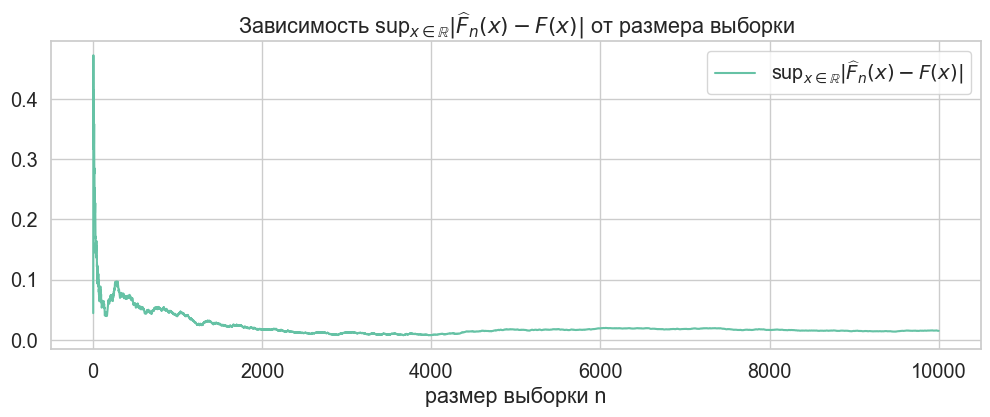

In [37]:
plt.figure(figsize=(12, 4))
plt.plot(np.arange(n) + 1, Dn, label='sup$_{x\in\mathbb{R}}|\widehat F_n(x) - F(x)|$')
plt.title('Зависимость sup$_{x\in\mathbb{R}}|\widehat F_n(x) - F(x)|$ от размера выборки')
plt.xlabel('размер выборки n')
plt.legend()
plt.show()

Посмотрим поближе

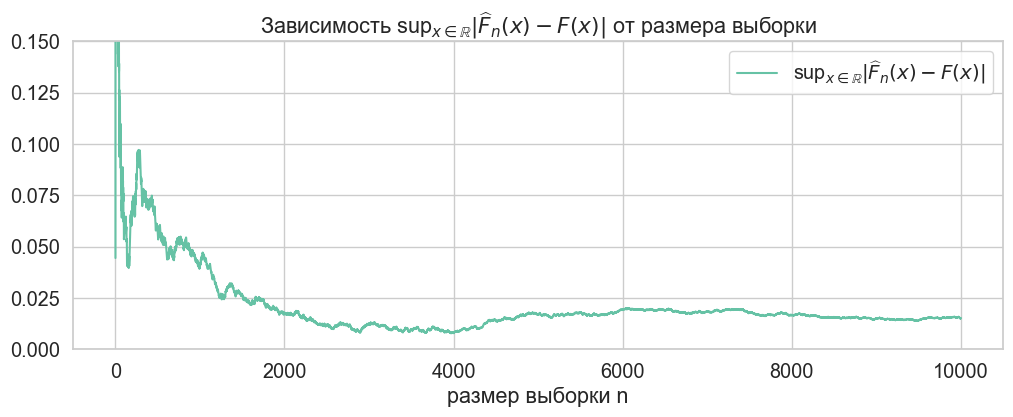

In [39]:
plt.figure(figsize=(12, 4))
plt.plot(np.arange(n) + 1, Dn, label='sup$_{x\in\mathbb{R}}|\widehat F_n(x) - F(x)|$')
plt.title('Зависимость sup$_{x\in\mathbb{R}}|\widehat F_n(x) - F(x)|$ от размера выборки')
plt.xlabel('размер выборки n')
plt.ylim(0, 0.15)
plt.legend()
plt.show()

При вычислении значения статистики мы учитывали только точки из отрезка между минимумом и максимумом сгенерированной выборки. Покажем, что значение статистики точное:

$\forall x < X_{(1)} верно, что  \widehat F_n(x) = 0$, 

$\forall x > X_{(n)} верно, что  \widehat F_n(x) = 1$. 

Так как $F$ монотонно возрастает, 

$\forall x < X_{(1)} верно, что F(x) > 0, |\widehat F_n(x) - F(x)| < |\widehat F_n(X_{(1)}) - F(X_{(1)})|$ и 

$\forall x > X_{(n)} F(x) < 1, |\widehat F_n(x) - F(x)| < |\widehat F_n(X_{(n)}) - F(X_{(n)})|$.

Таким образом, точки вне отрезка между минимумом и максимумом выборки не влияют на супремум. 

$D_n$ стремится к нулю почти всюду.

**Вывод:** 

Показали справедливость теоремы Гливенко-Кантелли на практике

---

### Задача 3.

В этой задаче вы исследуете различные непараметрические оценки распределений.
Для этого вам выдается почти готовый код функций `draw_ecdf`, `draw_hist` и `draw_pdf`, которые используются для построения ЭФР, гистограммы и ядерной оценки плотности соответственно. В реализациях этих функция часть кода пропущена, вам нужно его дописать. Код предполагает использование реализации ядерных оценок плотности из `statsmodels`.
При желании вы можете написать аналогичный код, используя реализацию в `seaborn`.

In [44]:
def draw_ecdf(sample, grid, cdf=None):
    """
    По сетке cтроит графики эмпирической функции распределения 
    и истинной (если она задана) для всей выборки и для 1/10 ее части.
    
    Вход:
        sample: выборка
        grid: сетка
        cdf: истинная функция распределения из scipy.stats
    """
    
    plt.figure(figsize=(16, 3))
    # Выбирается размер выборки
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        # Отрисовываются точки выборки на графике    
        plt.scatter(
            sample[:size], np.zeros(size),
            alpha=0.4, label='sample'
        )
        
        # Если передана истинная функция распределения, 
        # отрисовывается ее график
        if cdf is not None:
            plt.plot(
                grid,
                cdf(grid),
                color='green', alpha=0.3, lw=2, label='true cdf'
            )
        
        # Отрисовывается эмпирическую функцию распределения
        ecdf = ECDF(sample[:size])
        plt.plot(
            grid,
            ecdf(grid),
            color='red', label='ecdf'
        )
        
        plt.legend()
        plt.grid(ls=':')
        plt.title('sample size = {}'.format(size))
    plt.show()

In [41]:
def draw_hist(sample, grid, pdf=None):
    """
    Строит гистограмму и, по сетке, график истинной плотности 
    (если она задана) для всей выборки и для 1/10 ее части.
    
    Вход:
        sample: выборка
        grid: сетка
        pdf: истинная плотность из scipy.stats
    """
    
    plt.figure(figsize=(16, 3))
    # Выбирается размер выборки
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        # Построение гистограммы для выборки
        plt.hist(
            sample[:size],
            bins=20,
            range=(grid.min(), grid.max()),
            density=True, label='sample hist'
        )
        
        # Если передана истинная плотность, отрисовывается ее график
        if pdf is not None:
            plt.plot(
                grid,
                pdf(grid),
                color='green', alpha=0.3, lw=2, label='true pdf'
            )
        
        plt.legend()
    plt.show()

In [42]:
def draw_pdf(sample, grid, pdf=None):
    """
    По сетке cтроит графики ядерной оценки плотности 
    и истинной плотности (если она задана) для всей выборки 
    и для 1/10 ее части.
    
    Вход:
        sample: выборка
        grid: сетка
        pdf: истинная плотность из scipy.stats
    """
    
    plt.figure(figsize=(16, 3))
    # Выбирается размер выборки
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        # Отрисовка точек выборки на графике
        plt.scatter(
            sample[:size], np.zeros(size), 
            alpha=0.4, label='sample'
        )
        
        # Если передана истинная плотность, отрисовывается ее график
        if pdf is not None:
            plt.plot(
                grid,
                pdf(grid), 
                color='green', alpha=0.3, lw=2, label='true pdf'
            )
        
        # Отрисовывается KDE
        kde = KDEUnivariate(sample[:size])
        kde.fit()
        plt.plot(
            grid,
            kde.evaluate(grid),
            color='red', label='kde'
        )
        
        plt.legend()
        plt.grid(ls=':')
    plt.show()

Используя реализованные выше функции, постройте график эмпирической функции распределения (ЭФР), гистограмму и график ядерной оценки плотнотности к выборкам размера 500 для следующих распределений:

*1. Равномерное распределение $U[0,1]$*. Графики функции распределения и плотностей строить на интервале $(-0.2, 1.2)$.

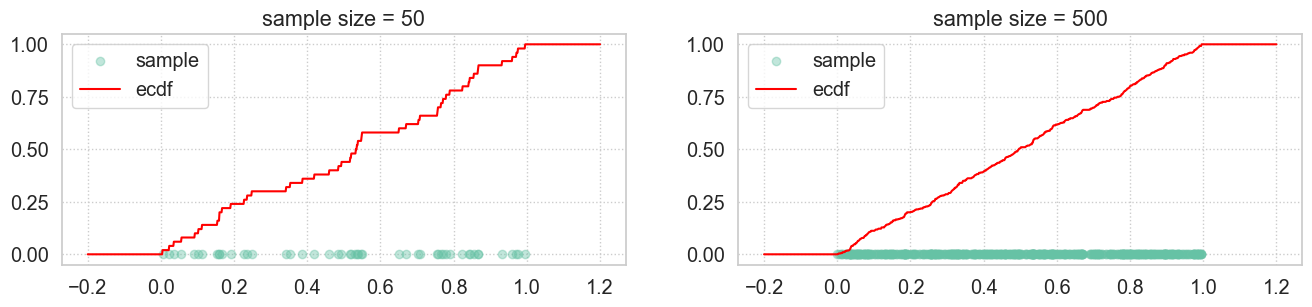

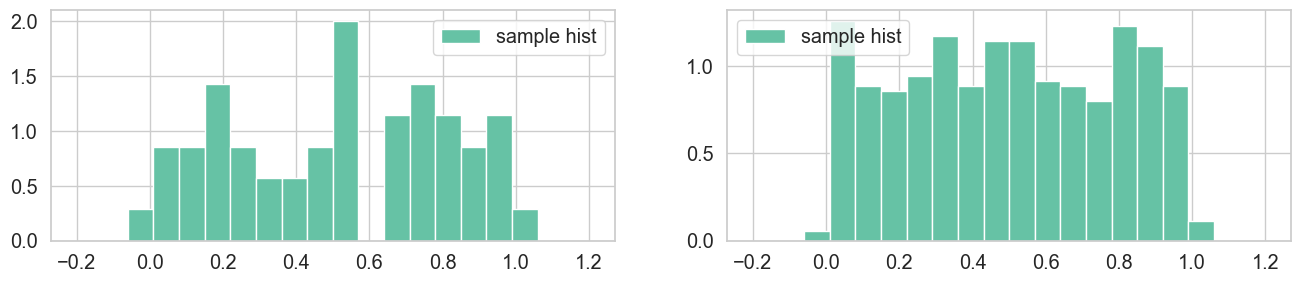

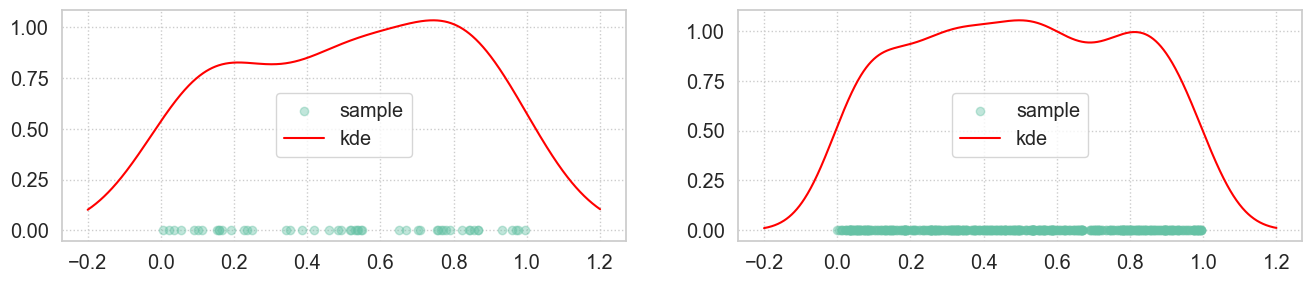

In [45]:
sample = sps.uniform(0, 1).rvs(size=(500,))
grid = np.linspace(-0.2, 1.2, 1000)

draw_ecdf(sample, grid)
draw_hist(sample, grid)
draw_pdf(sample, grid)

*2. Нормальное распределение $\mathcal{N}(0, 1)$.* Графики функции распределения и плотностей строить на интервале $(-3, 3)$.

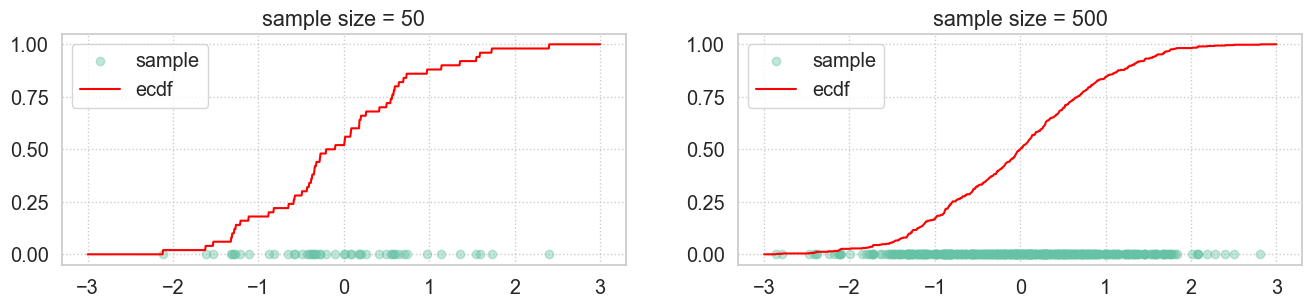

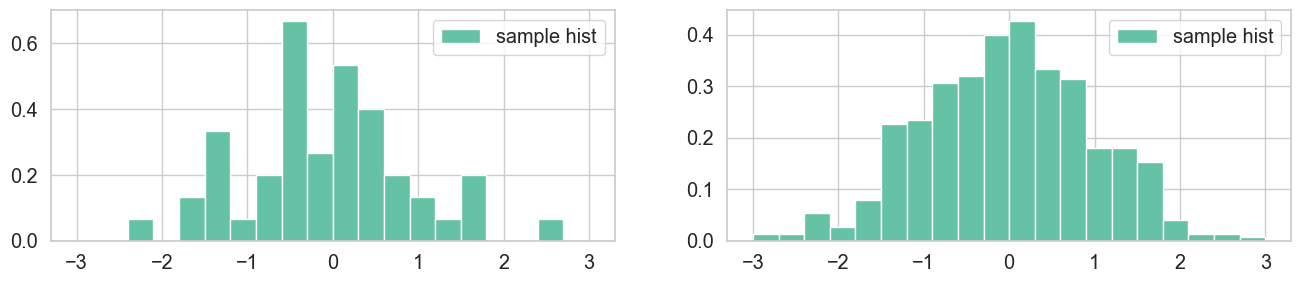

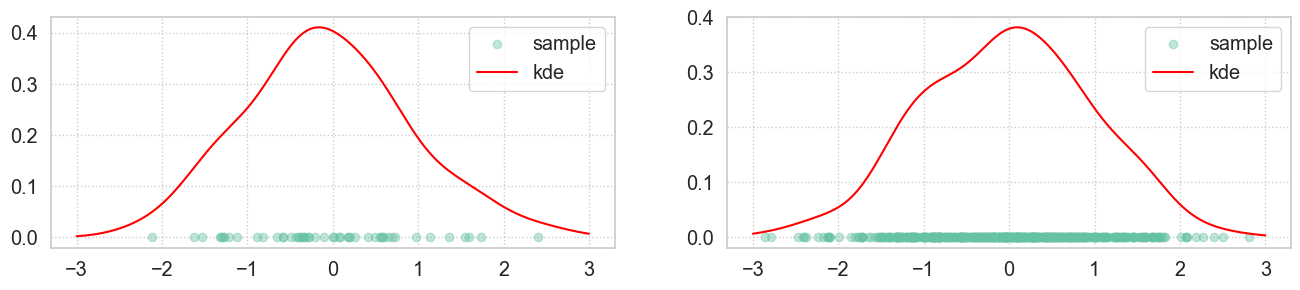

In [46]:
sample = sps.norm().rvs(size=(500,))
grid = np.linspace(-3, 3, 1000)

draw_ecdf(sample, grid)
draw_hist(sample, grid)
draw_pdf(sample, grid)

*3. Экспоненциальное распределение $Exp(1)$.* Графики функции распределения и плотностей  строить на интервале $(-0.5, 5)$.

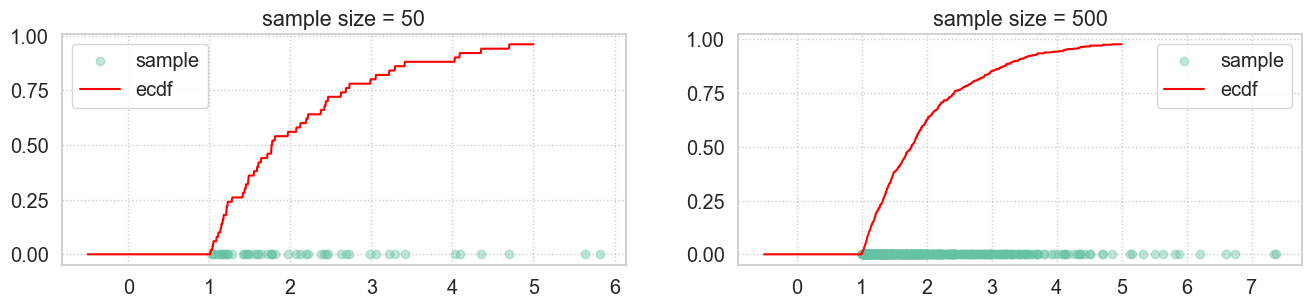

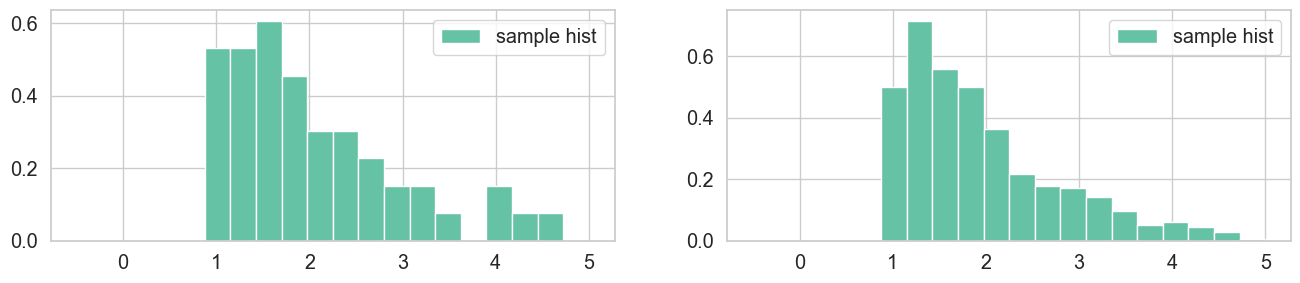

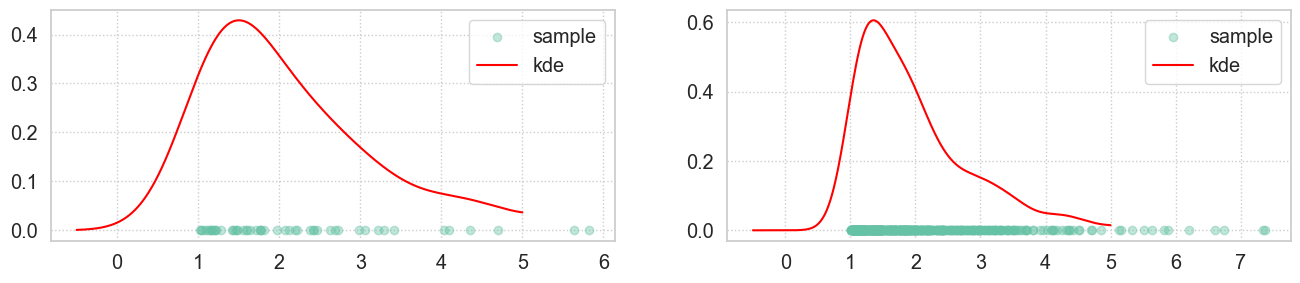

In [47]:
sample = sps.expon(1).rvs(size=(500,))
grid = np.linspace(-0.5, 5, 1000)

draw_ecdf(sample, grid)
draw_hist(sample, grid)
draw_pdf(sample, grid)

Опишите полученные результаты, сравните их между выборками из различных распределений.

**Вывод:**

Очевидно, что при увеличении размера выборки гистограммы начинают напоминать теоритическую плотность соответствующего распределения, а ЭФР теор функцию распределения. Ядерная оценка плотности по форме похожа на гистограмму. Также при увеличении размера выборки ЭФР становится более гладкой.
Ядерная оценка плотности имеет хвосты, выходящие за элементы выборки, однако с увеличением размера выборки хвосты приближаются к крайним значениям выборки.



---
### Задача 4.

Исследуйте вид ядерной оценки плотности в зависимости от вида ядра и его ширины.

Для этого сгенерируйте выборку $X_1, ..., X_{200}$ из распределения $U[0, 1]$ и постройте серию графиков для различной ширины гауссовского ядра, а затем другую серию графиков для различных типов ядер при фиксированной ширине. На каждом графике на отрезке $[-0.2, 1.2]$ должны быть изображены истинная плотность (полупрозрачным цветом) и ее ядерная оценка, а так же с нулевой $y$-координатой должны быть нанесены точки выборки. Для экономии места стройте графики в два столбца.

Вам выдется почти готовый код для выполнения задания с некоторыми пропусками. Код предполагает использование реализации ядерных оценок плотности из `statsmodels`. При желании вы можете написать аналогичный код, используя реализацию в `seaborn`. При построении KDE разрешается использовать цикл.

Смотрим зависимость от ширины ядра для различных типов ядер

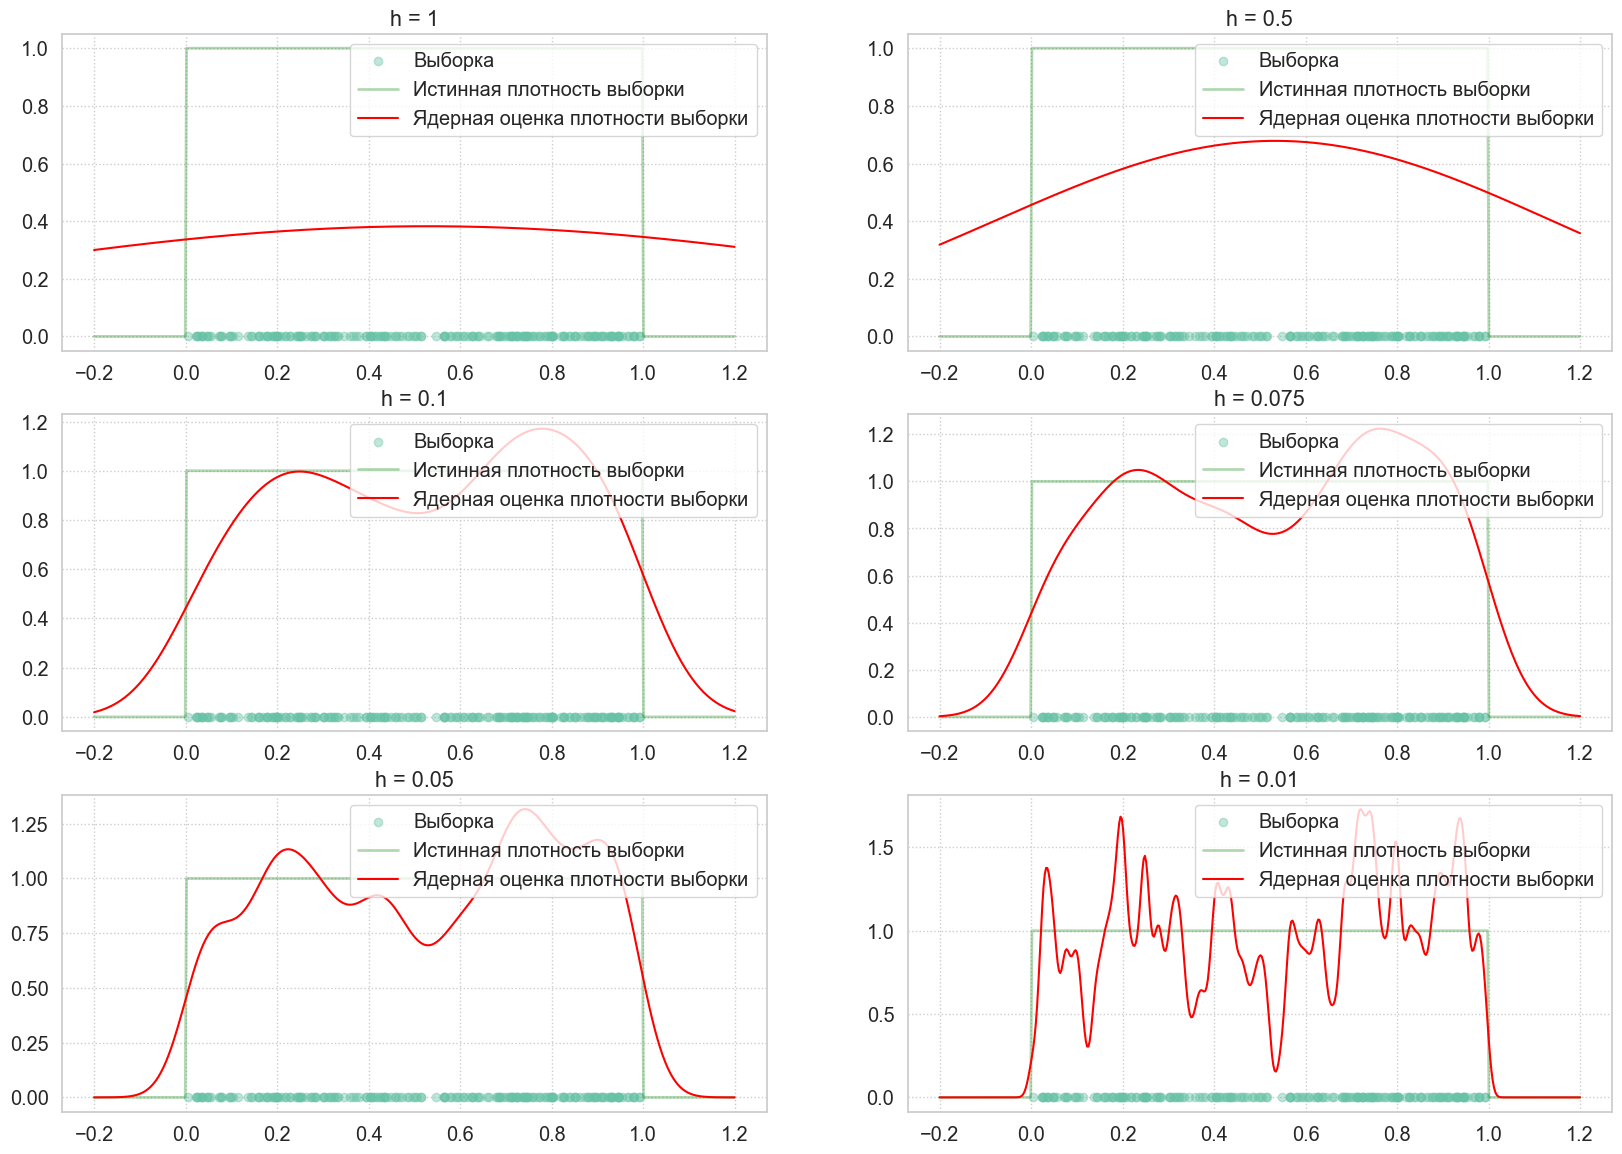

In [50]:
# Размер выборки
size = 200
# Выборка размера size
sample = sps.uniform(0, 1).rvs(size=(size,))
# Сетка на отрезке из условия
grid = np.linspace(-0.2, 1.2, 500)

plt.figure(figsize=(20, 14))

# Итераций по ширине ядра
for i, bw in enumerate([1, 0.5, 0.1, 0.075, 0.05, 0.01]):
    plt.subplot(3, 2, i + 1)
    # Построение KDE
    kernel_density = KDEUnivariate(sample[:size])
    kernel_density.fit(bw=bw)
    # Отображение элементов выборки
    plt.scatter(sample, np.zeros(size), alpha=0.4, label='Выборка')
    # Построение истинной плотности выборки
    plt.plot(grid, sps.uniform(0, 1).pdf(grid), color='green', 
             alpha=0.3, lw=2, label='Истинная плотность выборки')
    # Отображение KDE плотности
    plt.plot(grid, kernel_density.evaluate(grid),
             color='red', label='Ядерная оценка плотности выборки')
    plt.legend(loc=1)
    plt.grid(ls=':')
    plt.title('h = {}'.format(bw))
plt.show()

Во втором случае графики постройте аналогичным образом, проведя итерации по типу ядра.

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (500,) + inhomogeneous part.

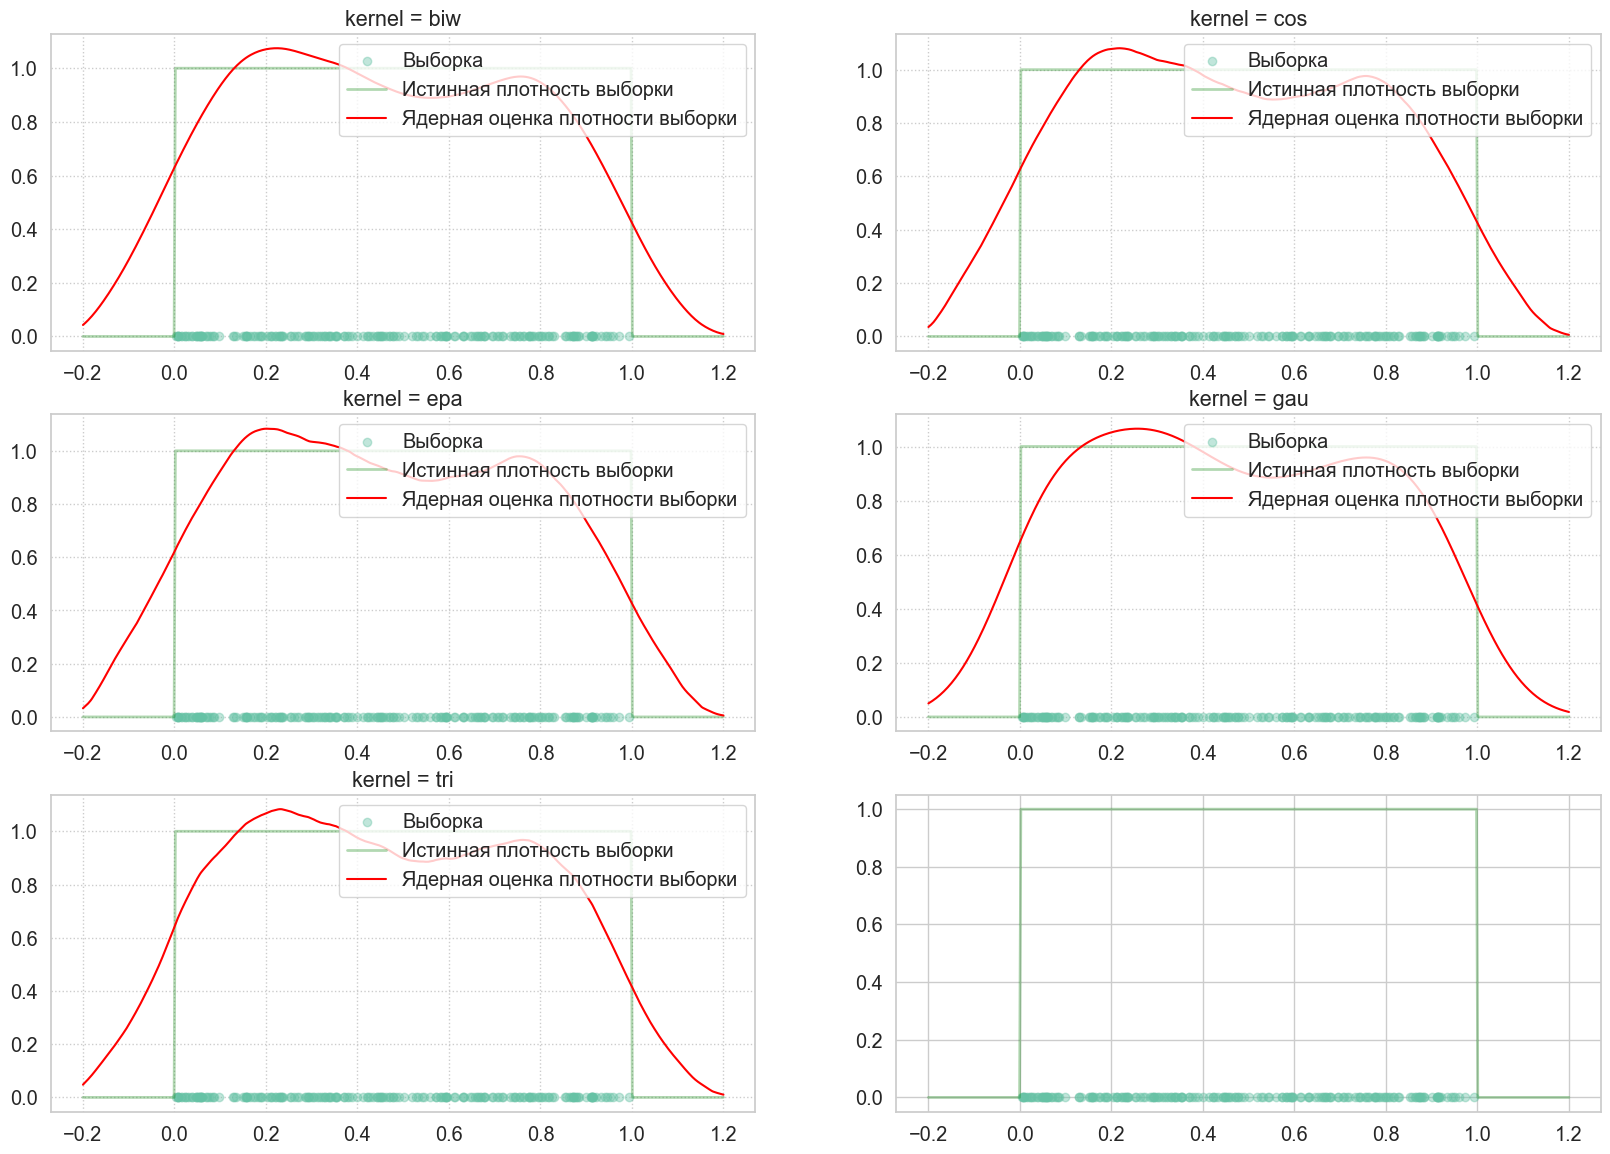

In [57]:
# Размер выборки
size = 200
# Выборка размера size
sample = sps.uniform(0, 1).rvs(size=(size,))
# Сетка на отрезке из условия
grid = np.linspace(-0.2, 1.2, 500)

plt.figure(figsize=(20, 14))

for i, kernel in enumerate(['biw', 'cos', 'epa', 'gau', 'tri', 'uni']):
    plt.subplot(3, 2, i + 1)
    # Построение KDE
    kernel_density = KDEUnivariate(sample[:size])
    kernel_density.fit(kernel=kernel, fft=False)
    # Отображение элементов выборки
    plt.scatter(sample, np.zeros(size), alpha=0.4, label='Выборка')
    # Построение истинной плотности выборки
    plt.plot(grid, sps.uniform(0, 1).pdf(grid), color='green',
             alpha=0.3, lw=2, label='Истинная плотность выборки')
    # Проверка результата evaluate
    y = np.array([kernel_density.evaluate(x) for x in grid])  # Получаем значение для каждого x
    plt.plot(grid, y, color='red', label='Ядерная оценка плотности выборки')
    plt.legend(loc=1)
    plt.grid(ls=':')
    plt.title(f'kernel = {kernel}')
plt.show()

**Вывод:**

1. Если ширина ядра слишком большая (h=0.5, 1), то его носитель получается намного шире самой выборки и получаются очень тяжелые хвосты.
Если же ширина ядра слишком маленькая (h=0.01), то результат похож на переобучение, то есть модель уже не находит общие зависимости, а просто подсраивается под данные обучающей выборки.

2. По типу ядра графики почти не отличаются. Просто некоторые более гладкие.

---
### Задача 5.

Рассмотрим задачу регрессии. Мы уже научились оценивать зависимость $y(x)$, но это только точечная оценка для каждого конкретного $x$. На практике бывает необходимо строить доверительные интервалы, которые в совокупности образуют доверительные ленты. Поскольку мы ничего не знаем про распределение ошибок, будем строить доверительную ленту по методу бутстрепа.

1. Сгенерируем достаточно большое число бутстрепных выборок.

2. Обучим модели и получим значения $\widehat{y}(x)$, для всех значений $x$ по сетке значений.

3. По предсказаным значениям оценим верхнюю и нижнюю границы ленты с помощью методов построения бутстрепных доверительных интервалов.

Напишите функцию, которая реализует данный метод

In [20]:
def bootstrap_confidence_interval(
    X, Y, model, X_grid, bootstrap_count=10000, alpha=0.95, model_args=None
):
    '''
    Построение предсказательной ленты для модели регрессии.
    
    X, Y - выборка;
    model - класс модели;
    X_grid - сетка для доверительной ленты;
    alpha - уровень доверия;
    bootstrap_count - количество бутстрепных выборок
    model_args - параметры модели.
    '''
    
    predictions = []

    for _ in tqdm(np.arange(bootstrap_count)):
        bootstrap_model = model
        n = X.shape[0]
        idx = np.random.randint(0, n, size=(n,))
        bootstrap_X, bootstrap_y = X[idx], Y[idx]
        bootstrap_model.fit(bootstrap_X, bootstrap_y)
        predictions.append(bootstrap_model.predict(X_grid))

    z = sps.norm().ppf((1+alpha)/2)
    predictions = np.array(predictions)
    mean = predictions.mean(axis=0)
    std = predictions.std(axis=0)
    lower_bound = mean - z * std
    upper_bound = mean + z * std

    return lower_bound, mean, upper_bound

Рассмотрим датасет cps71 из семинара

In [21]:
data = pd.read_csv('cps71.csv', index_col=0)
data.head()

,logwage,age
1,11.1563,21
2,12.8131,22
3,13.0960,22
4,11.6952,22
5,11.5327,22


Разделим нашу выборку на обучающую и тестовую

In [22]:
X_train, X_test, y_train, y_test = train_test_split(np.array(data['age']), np.array(data['logwage']), test_size=0.1)

Постройте доверительные ленты для моделей линейной регрессии, ядерной регрессии и KNN-регрессии.
Изобразите на графике также предсказания каждой модели и обучающую выборку.

*Примечание: для классов из statmodels сигнатура класса может не совпадать со стандартной, поэтому сделайте для этих классов, класс-обертку, который в себе просто будет вызывать нужные методы.*

In [23]:
class KernelRegWrap():
    def __init__(self):
        pass

    def fit(self, X_train, y_train):
        self.kreg = KernelReg(endog=y_train, exog=X_train, var_type='c')

    def predict(self, X_test):
        return self.kreg.fit(X_test)[0]

models = [KNeighborsRegressor(), KernelRegWrap(), LinearRegression()]

bounds = []
labels = ['KNN рег', 'Яд. рег', 'Лин. рег']
for model in models:
    bounds.append(bootstrap_confidence_interval(X_train.reshape(-1, 1), y_train.reshape(-1, 1), model, X_test.reshape(-1, 1), bootstrap_count=10))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

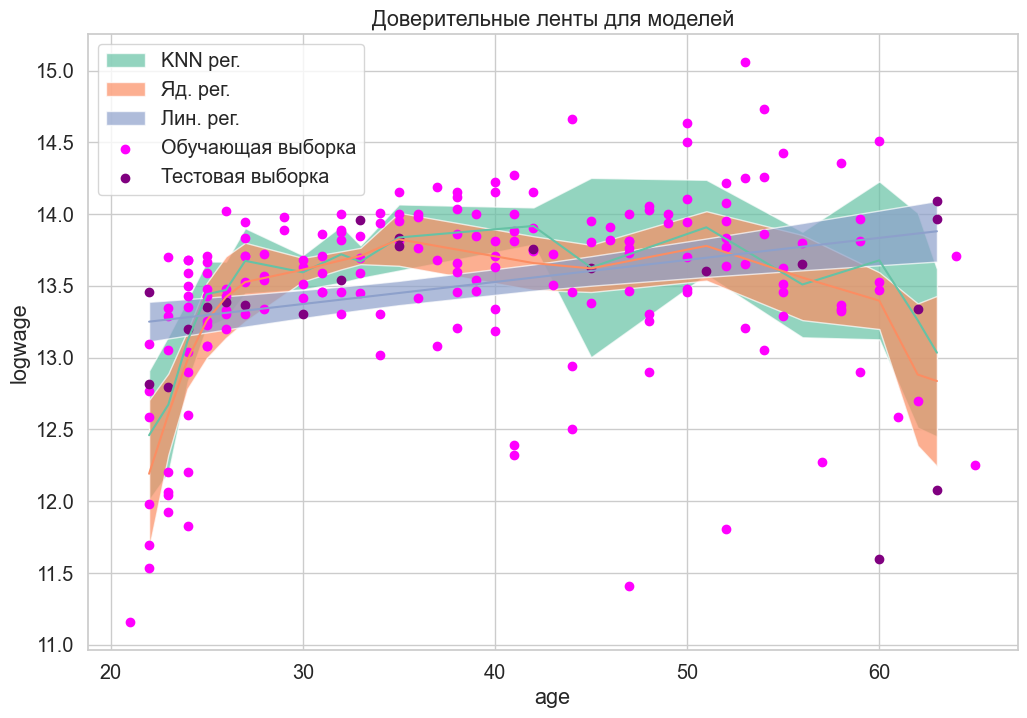

In [24]:
plt.figure(figsize=(12, 8))
colors = ['green', 'blue', 'red']

for i, bound in enumerate(bounds):
    left, est, right = bound
    order = np.argsort(X_test)
    plt.fill_between(X_test[order], left[order].squeeze(), right[order].squeeze(), alpha=0.7, label=labels[i])
    plt.plot(X_test[order], est[order])

plt.scatter(X_train, y_train, color='magenta', label='Обучающая выборка')
plt.scatter(X_test, y_test, color='purple', label='Тестовая выборка')
plt.title('Доверительные ленты для моделей')
plt.xlabel('age')
plt.ylabel('logwage')
plt.legend()
plt.show()

Сделайте выводы

**Вывод:**

Интервал для линейной регрессии практически не покрывает точки выборки, он слишком узкий.
KNN и ядерная регрессия имеют более широкие интервалы и значительно лучше покрывают точки выборки